In [1]:
%load_ext autoreload
%autoreload 2

from meteo_lib import PROJECT  # または: from meteo_lib.paths import PROJECT
from meteo_lib.my_path_utils import DATA, OUT

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from matplotlib.dates import DateFormatter
import datetime as dt
import matplotlib.dates as mdates
import matplotlib as mpl
mpl.rcParams["font.family"] = "IPAexGothic"   # 例：Noto Sans CJK JP でも可
mpl.rcParams["axes.unicode_minus"] = False    # －が豆腐になるのを回避

import pymannkendall as mk

place = '仙台'
start_year, end_year = 1926, 2024
Path = OUT / f'日毎データ_{place}_summary.parquet'
df = pd.read_parquet(Path)

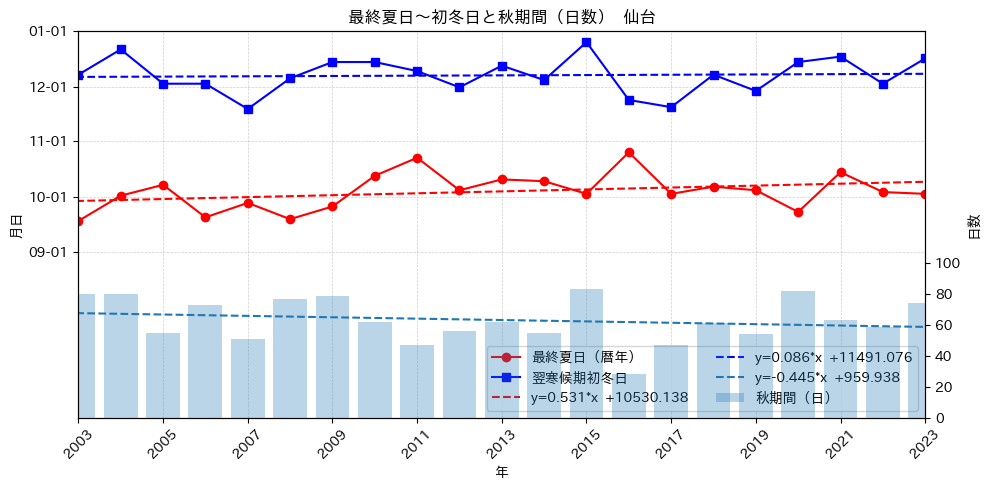

In [3]:
# ---- 秋期間の図化 ----
# summary: DataFrame に以下の列があること:
#   年, 最終夏日, 初冬日, 秋期間

REF_YEAR = 2001
FALL_COL = "秋期間"  # ←計算済みの列名をそのまま使用

df = df.copy().sort_values("年").reset_index(drop=True)
df["翌寒候期初冬日"] = df["初冬日"].shift(-1)  # 折れ線用：翌シーズンの初冬日

def to_refdate(s: pd.Series) -> pd.Series:
    # 年を消して「月日だけ」を基準年に載せ替え（NaTはNaTのまま）
    return pd.to_datetime(
        np.where(s.notna(), s.dt.strftime(f"{REF_YEAR}" + "-%m-%d"), pd.NaT),
        errors="coerce"
    )

final_summer_ref = to_refdate(df["最終夏日"])
next_first_winter_ref = to_refdate(df["翌寒候期初冬日"])
x = df["年"].astype(int).values

fig, ax1 = plt.subplots(figsize=(10, 5))

# 左軸：月日（折れ線）
ax1.plot(x, final_summer_ref, marker="o", color="red", label="最終夏日（暦年）")
ax1.plot(x, next_first_winter_ref, marker="s", color="blue", label="翌寒候期初冬日")
ax1.set_ylabel("月日")
ax1.yaxis.set_major_formatter(DateFormatter("%m-%d"))
ax1.set_xlabel("年")
x_min, x_max = 2003, 2023    # x軸表示範囲
ax1.set_xlim(x_min, x_max)
ticks = range(int(x_min), int(x_max)+1, 2)
ax1.set_xticks(ticks)

ax1.tick_params(axis='x', labelrotation=45)
y1_min = dt.date(REF_YEAR, 6, 1)
y1_max = dt.date(REF_YEAR + 1, 1, 1)
ax1.set_ylim(y1_min, y1_max)
# --- y軸ラベルを9月〜12月の1か月ごとに ---
tick_dates = pd.date_range(start=f"{REF_YEAR}-09-01", end=f"{REF_YEAR + 1}-01-01", freq="MS")
#tick_dates = pd.date_range(start=f"{REF_YEAR}-09-01", end=f"{REF_YEAR}-12-01", freq="MS")

# --- 回帰用：日付→float（日数）
y_fit_num_s = mdates.date2num(final_summer_ref)           # NaT → NaN
y_fit_num_w = mdates.date2num(next_first_winter_ref)      # NaT → NaN

# x が範囲内のマスク
mask_x = (x >= x_min) & (x <= x_max)

# 欠損を除いたインデックスを作る（少なくとも2点必要）
mask_s = np.isfinite(y_fit_num_s)
mask_w = np.isfinite(y_fit_num_w)

# ANDで統合
mask_s_use = mask_s & mask_x
mask_w_use = mask_w & mask_x

if mask_s.sum() >= 2:
    a_s, b_s = np.polyfit(x[mask_s_use], y_fit_num_s[mask_s_use], 1)
    y_line_num_s = a_s * x + b_s
    y_line_dt_s  = mdates.num2date(y_line_num_s)
    ax1.plot(x, y_line_dt_s, linestyle="--", color="red",
             label=f'y={a_s:.3f}*x  {b_s:+.3f}')
else:
    print("最終夏日の回帰は有効データ点が不足のためスキップ")

if mask_w.sum() >= 2:
    a_w, b_w = np.polyfit(x[mask_w_use], y_fit_num_w[mask_w_use], 1)
    y_line_num_w = a_w * x + b_w
    y_line_dt_w  = mdates.num2date(y_line_num_w)
    ax1.plot(x, y_line_dt_w, linestyle="--", color="blue",
             label=f'y={a_w:.3f}*x  {b_w:+.3f}')
else:
    print("初冬日の回帰は有効データ点が不足のためスキップ")

ax1.set_yticks(tick_dates)
ax1.yaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))


# 右軸：秋期間（日）（棒）
ax2 = ax1.twinx()
y = pd.to_numeric(df[FALL_COL], errors='coerce').fillna(0.0)
ax2.bar(x, y.values.astype("float"), alpha=0.3, label="秋期間（日）")
ax2.set_ylabel("日数")
ax2.set_ylim(0, 250)
ticks = list(range(0, 101, 20))
ax2.set_yticks(ticks)

x_use = x[mask_x]
y_use = y[mask_x]
a, b = np.polyfit(x_use, y_use, 1)
y = a * x + b
ax2.plot(x, y, linestyle="--", label=f'y={a:.3f}*x  {b:+.3f}')

# 凡例（統合）
handles, labels = [], []
for ax in (ax1, ax2):
    h, l = ax.get_legend_handles_labels()
    handles += h; labels += l
seen, h2, l2 = set(), [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen.add(l); h2.append(h); l2.append(l)
ax1.legend(h2, l2, loc="lower right", ncol=2)

ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.title(f"最終夏日〜初冬日と秋期間（日数）  {place}")
plt.tight_layout()

#plt.savefig(OUT / f'{place}_{start_year}-{end_year}_秋日数.png')
plt.savefig(OUT / f'{place}_{x_min}-{x_max}_秋日数.png')

plt.show()


In [4]:
# Theil-Sen estimator
def sens_slope(x, t):
    x = np.asarray(x, dtype=float)
    t = np.asarray(t, dtype=float)
    mask = np.isfinite(x) & np.isfinite(t)
    x = x[mask]
    t = t[mask]
    n = len(x)
    if n < 2:
        raise ValueError("データ点が少なすぎます。")

    slopes = []
    for i in range(n-1):
        for j in range(i+1, n):
            if t[j] != t[i]:
                slopes.append((x[j] - x[i]) / (t[j] - t[i]))
    slopes = np.array(slopes)
    slope = np.median(slopes)
    intercept = np.median(x - slope * t)
    return slope, intercept

In [5]:
def sens_slope_resid_bootstrap_ci(x, t, B=2000, alpha=0.05, random_state=None):
    """
    Theil–Sen slope の残差ブートストラップ CI（percentile 法）

    Parameters
    ----------
    x : array-like
        観測値（例：秋期間）
    t : array-like
        年（例：1950, 1951, ...）
    B : int
        ブートストラップ回数
    alpha : float
        有意水準（0.05 → 95% CI）
    random_state : int or None
        乱数シード（再現性用）

    Returns
    -------
    slope0 : float
        元データでの Theil–Sen slope
    ci_low : float
        傾きの下側信頼限界
    ci_high : float
        傾きの上側信頼限界
    """
    x = np.asarray(x, dtype=float)
    t = np.asarray(t, dtype=float)
    mask = np.isfinite(x) & np.isfinite(t)
    x = x[mask]
    t = t[mask]
    n = len(x)
    if n < 2:
        raise ValueError("データ点が少なすぎます。")

    rng = np.random.default_rng(random_state)

    # 1) 元データでの Theil–Sen slope と切片
    slope0, intercept0 = sens_slope(x, t)

    # 2) 残差を計算
    y_hat = slope0 * t + intercept0
    resid = x - y_hat

    # 3) ブートストラップ
    boot_slopes = np.empty(B)
    for b in range(B):
        # 残差を復元抽出
        e_star = rng.choice(resid, size=n, replace=True)

        # トレンド + 再サンプル残差 で疑似時系列を作る
        x_star = y_hat + e_star

        # 年はそのまま t を使う → 時系列構造を保持
        sb, _ = sens_slope(x_star, t)
        boot_slopes[b] = sb

    # 4) パーセンタイル CI
    ci_low = np.percentile(boot_slopes, 100 * alpha/2)
    ci_high = np.percentile(boot_slopes, 100 * (1 - alpha/2))

    print(f"Sen's slope = {slope0:.3f}")
    print(f"{int((1-alpha)*100)}% CI = [{ci_low:.3f}, {ci_high:.3f}]")

    return slope0, ci_low, ci_high


In [11]:
# Mann-Kendall test
# start_year–end_year のデータを対象とする
year_min = 1950
year_max = 2024
years = df["年"].to_numpy()
x = df["秋期間"].to_numpy()

mask_range = (df['年'] >= year_min) & (df['年'] <= year_max)
mask_al = mask_range & df["秋期間"].notna()
years_al = df.loc[mask_al, "年"].to_numpy()
x_al = df.loc[mask_al, "秋期間"].to_numpy()

r_o_al = mk.original_test(x_al)
r_h_al = mk.hamed_rao_modification_test(x_al)

print(r_o_al)
print(r_h_al)
slope0, lo, hi = sens_slope_resid_bootstrap_ci(
    x_al, years_al,
    B=5000, alpha=0.05, random_state=42
)

Mann_Kendall_Test(trend='increasing', h=True, p=0.003025739944670258, z=2.9651107361188873, Tau=0.23546834505738615, s=636.0, var_s=45863.333333333336, slope=0.25, intercept=45.875)
Modified_Mann_Kendall_Test_Hamed_Rao_Approach(trend='increasing', h=True, p=0.000325476769696742, z=3.5941304305404294, Tau=0.23546834505738615, s=636.0, var_s=31214.744428291076, slope=0.25, intercept=45.875)
Sen's slope = 0.250
95% CI = [0.103, 0.404]


In [12]:
from statsmodels.nonparametric.smoothers_lowess import lowess

def sens_slope(x, t):
    x = np.asarray(x, dtype=float)
    t = np.asarray(t, dtype=float)
    mask = np.isfinite(x) & np.isfinite(t)
    x = x[mask]
    t = t[mask]
    n = len(x)
    if n < 2:
        raise ValueError("データ点が少なすぎます。")

    slopes = []
    for i in range(n-1):
        for j in range(i+1, n):
            if t[j] != t[i]:
                slopes.append((x[j] - x[i]) / (t[j] - t[i]))
    slopes = np.array(slopes)
    slope = np.median(slopes)
    intercept = np.median(x - slope * t)
    return slope, intercept


def plot_loess_theilsen(
    years,
    values,
    title="",
    ylabel="",
    year_min=None,
    year_max=None,
    loess_frac=0.3,
    outpath=None,
):
    """
    年次データに対して
    ・散布図（観測値）
    ・LOESS 曲線
    ・Theil–Sen 直線
    を重ねて表示する。
    """

    years = np.asarray(years, dtype=float)
    values = np.asarray(values, dtype=float)

    # NaN 除去
    mask = np.isfinite(years) & np.isfinite(values)
    years = years[mask]
    values = values[mask]

    # 年順にソート
    order = np.argsort(years)
    years = years[order]
    values = values[order]

    if year_min is None:
        year_min = int(years.min())
    if year_max is None:
        year_max = int(years.max())

    # 対象期間だけに絞る
    mask_period = (years >= year_min) & (years <= year_max)
    yy = years[mask_period]
    xx = values[mask_period]

    # Theil–Sen 傾き・切片
    slope, intercept = sens_slope(xx, yy)

    # LOESS 平滑
    # lowess は (y, x) の順なので注意
    loess_res = lowess(xx, yy, frac=loess_frac, it=0, return_sorted=True)
    loess_x = loess_res[:, 0]  # 年
    loess_y = loess_res[:, 1]  # 平滑値

    # Theil–Sen 直線用
    x_line = np.linspace(year_min, year_max, 200)
    y_line = slope * x_line + intercept

    # プロット
    fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

    # 観測値
    ax.plot(yy, xx, "o", markersize=4, label="観測値")

    # LOESS 曲線
    ax.plot(loess_x, loess_y, "-", linewidth=2, label=f"LOESS (frac={loess_frac})")

    # Theil–Sen 直線
    ax.plot(x_line, y_line, "--", linewidth=2, label=f"Theil–Sen 直線 (slope={slope:.3f})")

    ax.set_xlabel("年")
    ax.set_ylabel(ylabel)
    if title:
        ax.set_title(title + f"（{year_min}–{year_max}）")

    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(frameon=False, fontsize=9)

    fig.tight_layout()

    if outpath is not None:
        fig.savefig(outpath, bbox_inches="tight")
        print("→ 図を保存しました:", outpath)

    return fig, ax, slope


→ 図を保存しました: /Users/takumi/Projects/JMA-data/outputs/Sendai_autumn_LOESS_TheilSen_1950_2024.png


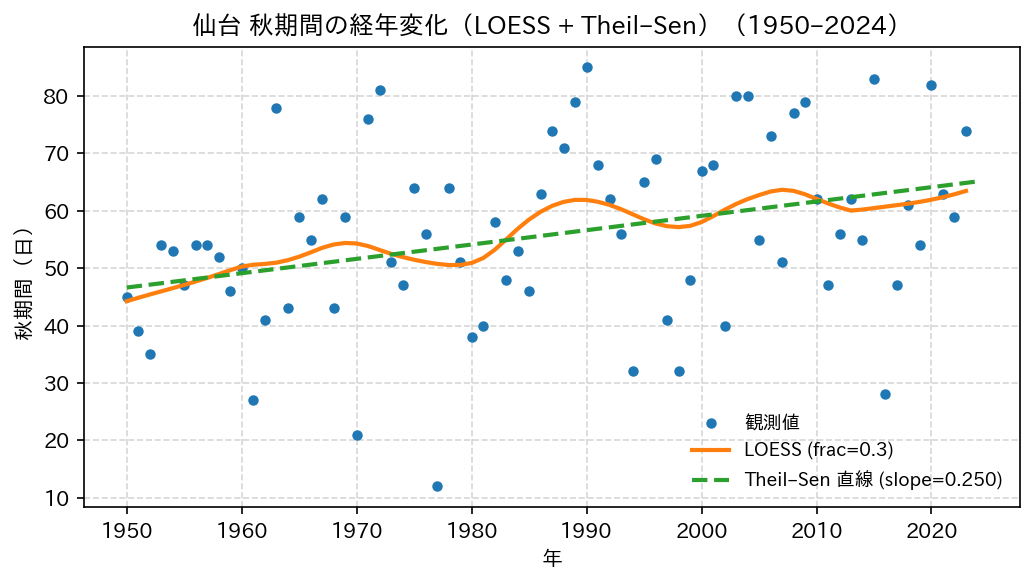

In [14]:
# 年でソートしておく
df = df.sort_values("年")

mask = (df["年"] >= 1950) & (df["年"] <= 2024)
years_al = df.loc[mask, "年"].to_numpy()
x_al     = df.loc[mask, "秋期間"].to_numpy()

fig, ax, slope = plot_loess_theilsen(
    years_al,
    x_al,
    title="仙台 秋期間の経年変化（LOESS + Theil–Sen）",
    ylabel="秋期間（日）",
    year_min=1950,
    year_max=2024,
    loess_frac=0.3,
    outpath=OUT / "Sendai_autumn_LOESS_TheilSen_1950_2024.png",
)


In [28]:
import numpy as np
import matplotlib.pyplot as plt
from statsmodels.nonparametric.smoothers_lowess import lowess

def plot_loess_theilsen_with_ci(
    years,
    values,
    title="",
    ylabel="",
    year_min=None,
    year_max=None,
    loess_frac=0.3,
    B=5000,
    alpha=0.05,
    random_state=42,
    outpath=None,
):
    years = np.asarray(years, dtype=float)
    values = np.asarray(values, dtype=float)

    # NaN 除去
    mask = np.isfinite(years) & np.isfinite(values)
    years = years[mask]
    values = values[mask]

    # 年順にソート
    order = np.argsort(years)
    years = years[order]
    values = values[order]

    if year_min is None:
        year_min = int(years.min())
    if year_max is None:
        year_max = int(years.max())

    # 対象区間
    mask_period = (years >= year_min) & (years <= year_max)
    yy = years[mask_period]
    xx = values[mask_period]

    # --- Theil–Sen slope と CI ---
    slope0, intercept0 = sens_slope(xx, yy)

    # 中央年でアンカー
    t0 = yy.mean()
    y0 = slope0 * t0 + intercept0

    # ブートストラップで CI
    slope0_bs, ci_low, ci_high = sens_slope_resid_bootstrap_ci(
        xx, yy, B=B, alpha=alpha, random_state=random_state
    )
    slope0 = slope0_bs

    # x 軸
    x_line = np.linspace(year_min, year_max, 200)

    # 3 本の線（中心年 t0 で揃える）
    y_mid  = y0 + slope0 * (x_line - t0)
    y_low  = y0 + ci_low  * (x_line - t0)
    y_high = y0 + ci_high * (x_line - t0)

    # --- LOESS ---
    loess_res = lowess(xx, yy, frac=loess_frac, it=0, return_sorted=True)
    loess_x = loess_res[:, 0]
    loess_y = loess_res[:, 1]

    # --- 図作成（ここで初めて ax が出てくる） ---
    fig, ax = plt.subplots(figsize=(7, 4), dpi=150)

    # CI 帯
    ax.fill_between(x_line, y_low, y_high, alpha=0.15, label="Theil–Sen 95% CI")

    # 中央線
    ax.plot(x_line, y_mid, "--", lw=2, label=f"Theil–Sen 直線 (slope={slope0:.3f})")

    # LOESS
    ax.plot(loess_x, loess_y, "-", lw=2, label=f"LOESS (frac={loess_frac})")

    # 観測値
    ax.plot(yy, xx, "o", markersize=4, label="観測値")

    ax.set_xlabel("年")
    ax.set_ylabel(ylabel)
    ax.set_title(f"{title}（{year_min}–{year_max}）")
    ax.grid(True, linestyle="--", alpha=0.5)
    ax.legend(frameon=False)

    fig.tight_layout()

    if outpath is not None:
        fig.savefig(outpath, bbox_inches="tight")
        print("→ 図を保存しました:", outpath)

    return fig, ax, slope0, ci_low, ci_high


Sen's slope = 0.250
95% CI = [0.103, 0.404]
→ 図を保存しました: /Users/takumi/Projects/JMA-data/outputs/Sendai_autumn_LOESS_TheilSen_CI_1950_2024.png
Sen's slope = 0.25
95% CI = 0.10344359070464768 0.4044307809330626


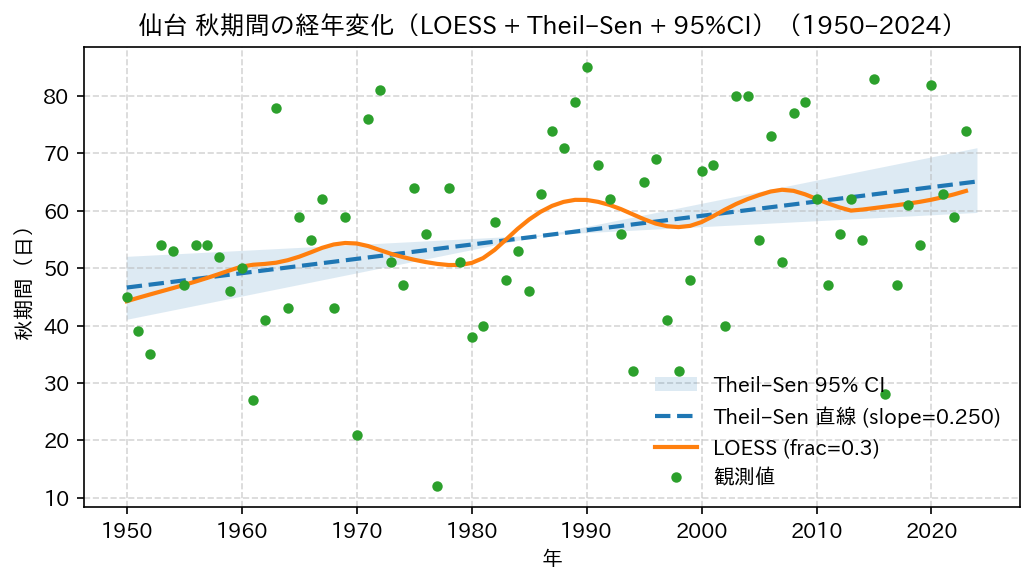

In [29]:
# 年でソートしておく
df = df.sort_values("年")

mask = (df["年"] >= 1950) & (df["年"] <= 2024)
years_al = df.loc[mask, "年"].to_numpy()
x_al     = df.loc[mask, "秋期間"].to_numpy()

fig, ax, slope0, lo, hi = plot_loess_theilsen_with_ci(
    years_al,
    x_al,
    title="仙台 秋期間の経年変化（LOESS + Theil–Sen + 95%CI）",
    ylabel="秋期間（日）",
    year_min=1950,
    year_max=2024,
    loess_frac=0.3,
    B=5000,
    alpha=0.05,
    random_state=42,
    outpath=OUT / "Sendai_autumn_LOESS_TheilSen_CI_1950_2024.png",
)

print("Sen's slope =", slope0)
print("95% CI =", lo, hi)


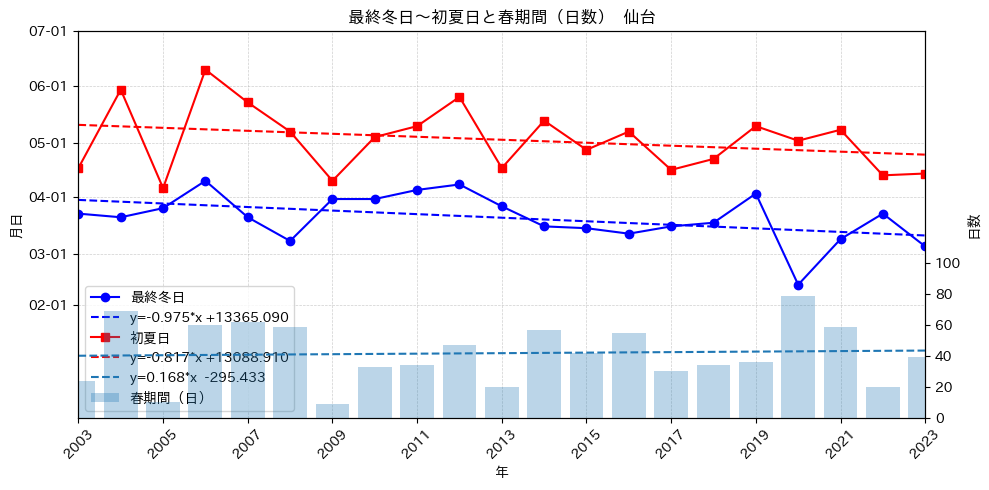

In [7]:
# ---- 春期間の図化 ----
# summary: DataFrame に以下の列があること:
#   年, 最終冬日, 初夏日, 春期間

REF_YEAR = 2001
FALL_COL = "春期間"  # ←計算済みの列名をそのまま使用

df = df.copy().sort_values("年").reset_index(drop=True)
#df["翌寒候期初冬日"] = df["初冬日"].shift(-1)  # 折れ線用：翌シーズンの初冬日

def to_refdate(s: pd.Series) -> pd.Series:
    # 年を消して「月日だけ」を基準年に載せ替え（NaTはNaTのまま）
    return pd.to_datetime(
        np.where(s.notna(), s.dt.strftime(f"{REF_YEAR}" + "-%m-%d"), pd.NaT),
        errors="coerce"
    )

final_winter_ref = to_refdate(df["最終冬日"])
first_summer_ref = to_refdate(df["初夏日"])
x = df["年"].astype(int).values

x_min = 2003
x_max = 2023
# x が範囲内のマスク
mask_x = (x >= x_min) & (x <= x_max)

fig, ax1 = plt.subplots(figsize=(10, 5))

# 左軸：月日（折れ線）
# y は datetime（NaT を含む想定）
ax1.plot(x, final_winter_ref, marker="o", color="blue", label="最終冬日")

ax1.set_xlim(x_min, x_max)
ticks = range(int(x_min), int(x_max)+1, 2)
ax1.set_xticks(ticks)

y_dt = pd.to_datetime(final_winter_ref)
# 欠損を除外し、x と y の長さを揃える
mask = y_dt.notna() & mask_x
x_fit = np.asarray(x, dtype=float)[mask]
y_fit = mdates.date2num(y_dt[mask])   # ← 日付 → float（日単位）

# 点が2つ以上ある時だけ回帰
if x_fit.size >= 2:
    a, b = np.polyfit(x_fit, y_fit, 1)
    y_line = a * x_fit + b
    # 描画は datetime に戻す
    ax1.plot(x_fit, mdates.num2date(y_line), color="blue", linestyle="--",
             label=f"y={a:.3f}*x {b:+.3f}")
else:
    print("[DEBUG] winter fit skipped (<2 points)")

ax1.plot(x, first_summer_ref, marker="s", color="red", label="初夏日")

# y は datetime（NaT を含む想定）
y_dt = pd.to_datetime(first_summer_ref)

# 欠損を除外し、x と y の長さを揃える
mask = y_dt.notna() & mask_x
x_fit = np.asarray(x, dtype=float)[mask]
y_fit = mdates.date2num(y_dt[mask])   # ← 日付 → float（日単位）

# 点が2つ以上ある時だけ回帰
if x_fit.size >= 2:
    a, b = np.polyfit(x_fit, y_fit, 1)
    y_line = a * x_fit + b
    # 描画は datetime に戻す
    ax1.plot(x_fit, mdates.num2date(y_line), color="red", linestyle="--",
             label=f"y={a:.3f}*x {b:+.3f}")
else:
    print("[DEBUG] winter fit skipped (<2 points)")

ax1.set_ylabel("月日")
ax1.yaxis.set_major_formatter(DateFormatter("%m-%d"))
ax1.set_xlabel("年")
ax1.tick_params(axis='x', labelrotation=45)
y1_min = dt.date(REF_YEAR - 1, 12, 1)
y1_max = dt.date(REF_YEAR, 7, 1)
ax1.set_ylim(y1_min, y1_max)
# --- y軸ラベルを3月〜6月の1か月ごとに ---
tick_dates = pd.date_range(start=f"{REF_YEAR}-02-01", end=f"{REF_YEAR}-07-01", freq="MS")
#tick_dates = pd.date_range(start=f"{REF_YEAR}-09-01", end=f"{REF_YEAR}-07-01", freq="MS")
ax1.set_yticks(tick_dates)
ax1.yaxis.set_major_formatter(mdates.DateFormatter("%m-%d"))


# 右軸：春期間（日）（棒）
ax2 = ax1.twinx()
y = pd.to_numeric(df[FALL_COL], errors='coerce').fillna(0.0)
ax2.bar(x, y.values.astype("float"), alpha=0.3, label="春期間（日）")
x = x[mask_x]
y = y[mask_x]
a, b = np.polyfit(x, y.values.astype("float"), 1)
y = a * x + b
ax2.plot(x, y, linestyle="--", label=f'y={a:.3f}*x  {b:+.3f}')

ax2.set_ylabel("日数")
ax2.set_ylim(0, 250)
ticks = list(range(0, 101, 20))
ax2.set_yticks(ticks)


# 凡例（統合）
handles, labels = [], []
for ax in (ax1, ax2):
    h, l = ax.get_legend_handles_labels()
    handles += h; labels += l
seen, h2, l2 = set(), [], []
for h, l in zip(handles, labels):
    if l not in seen:
        seen.add(l); h2.append(h); l2.append(l)
#ax1.legend(h2, l2, loc="best")
ax1.legend(h2, l2, loc='lower left')

ax1.grid(True, linestyle="--", linewidth=0.5, alpha=0.6)
plt.title(f"最終冬日〜初夏日と春期間（日数）  {place}")
plt.tight_layout()

plt.savefig(OUT / f'{place}_{start_year}-{end_year}_春日数.png')

plt.show()


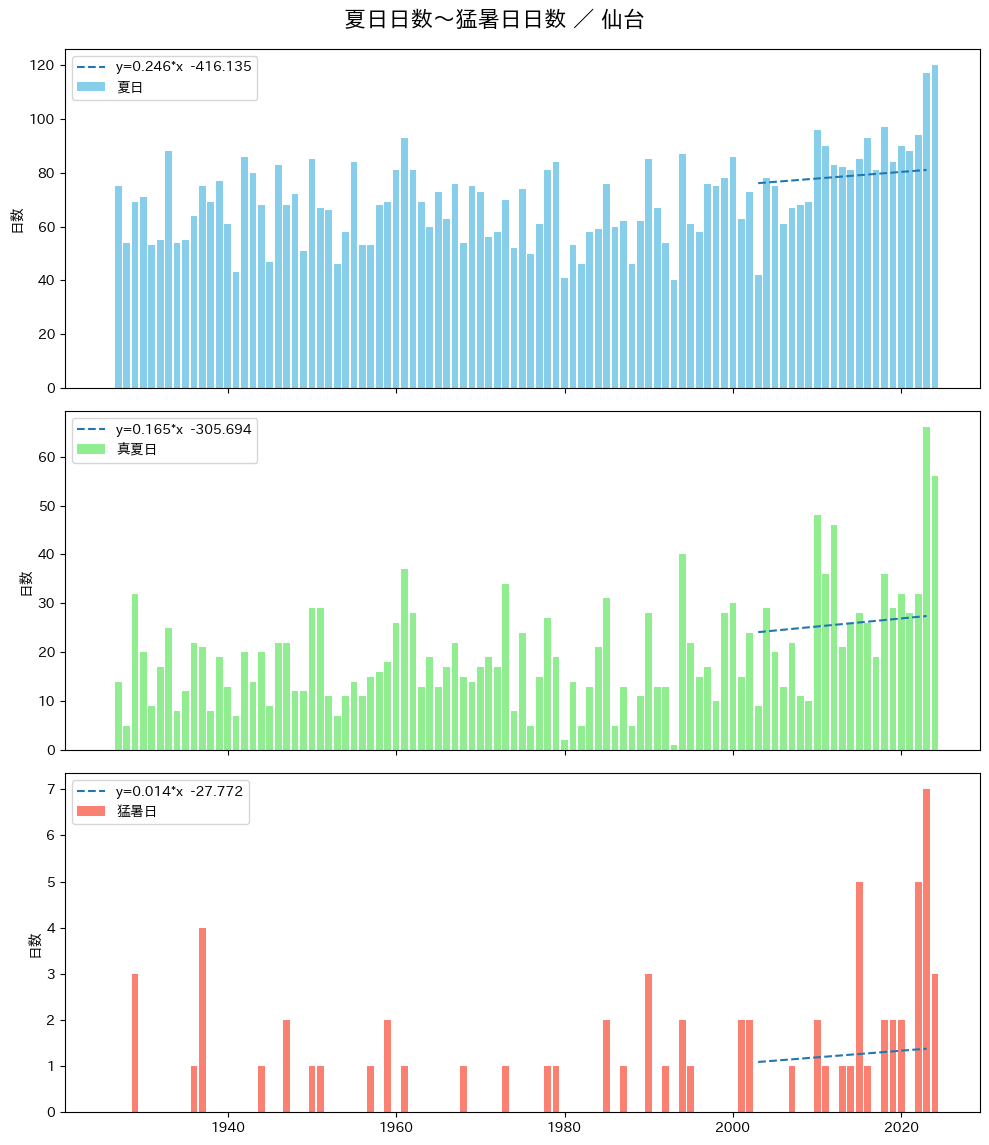

In [8]:
# ---- 夏日・真夏日・猛暑日の推移 ----
# summary: DataFrame に以下の列があること:
#   年, 夏日日数, 真夏日日数, 猛暑日日数

df = df.copy().sort_values("年").reset_index(drop=True)

fig, axes = plt.subplots(nrows=3, ncols=1, figsize=(10, 12), sharex=True)

labels = ["夏日", "真夏日", "猛暑日"]
colors = ["skyblue", "lightgreen", "salmon"]

for ax, col, lab in zip(axes, ["夏日日数", "真夏日日数", "猛暑日日数"], labels):
    ax.bar(df["年"], df[col], color=colors.pop(0), label=lab)
    a, b = np.polyfit(df["年"], df[col], 1)
    y = a * x + b
    ax.plot(x, y, linestyle="--", label=f'y={a:.3f}*x  {b:+.3f}')

    ax.set_ylabel("日数")
    ax.legend()

fig.suptitle(f'夏日日数〜猛暑日日数 ／ {place}', fontsize=16, y=0.95)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(OUT / f'{place}_{start_year}-{end_year}_夏日日数.png')
plt.show()
#fig

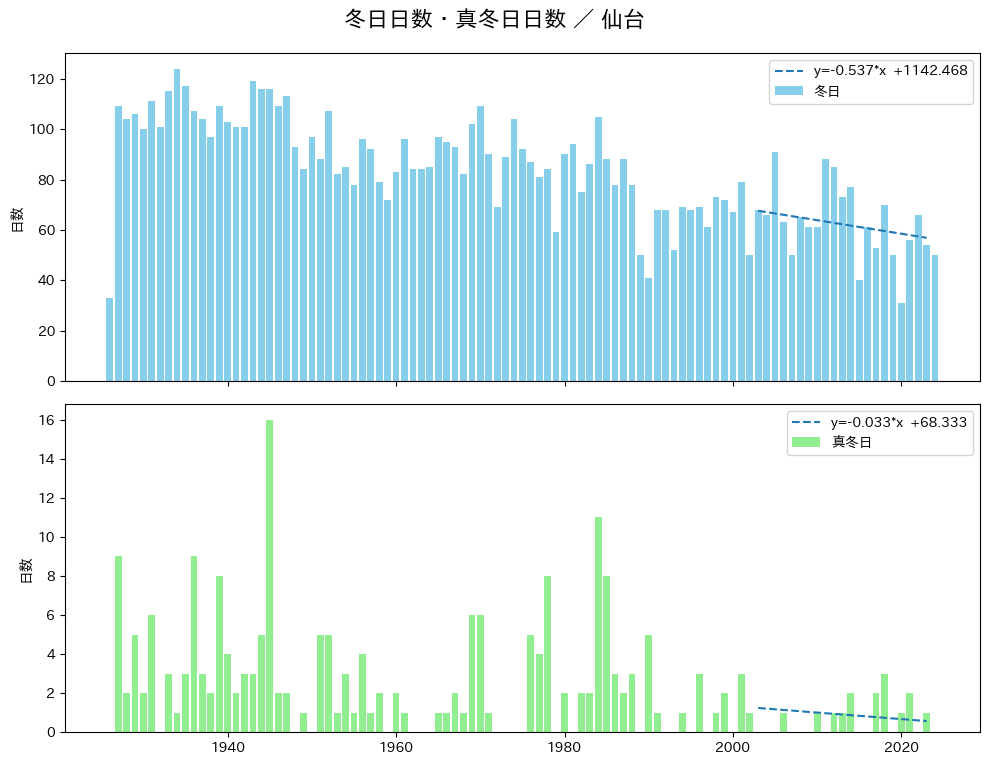

In [9]:
# ---- 冬日・真冬日の日数 ----
# summary: DataFrame に以下の列があること:
#   年, 冬日日数, 真冬日日数

df = df.copy().sort_values("年").reset_index(drop=True)

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 8), sharex=True)

labels = ["冬日", "真冬日"]
colors = ["skyblue", "lightgreen"]

for ax, col, lab in zip(axes, ["冬日日数", "真冬日日数"], labels):
    ax.bar(df["年"], df[col], color=colors.pop(0), label=lab)
    a, b = np.polyfit(df["年"], df[col], 1)
    y = a * x + b
    ax.plot(x, y, linestyle="--", label=f'y={a:.3f}*x  {b:+.3f}')

    ax.set_ylabel("日数")
    ax.legend()

fig.suptitle(f'冬日日数・真冬日日数 ／ {place}', fontsize=16, y=0.95)
fig.tight_layout(rect=[0, 0, 1, 0.96])
plt.savefig(OUT / f'{place}_{start_year}-{end_year}_冬日日数.png')
plt.show()
#fig